<a href="https://colab.research.google.com/github/peremartra/Rearchitecting-LLMs/blob/main/CH06/CH06_NB02_Logits_KLD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Rearchitecting LLMs**
## **Chapter 6: Knowledge Distillation with Logits Only**
### Training a pruned model using only Logits and Skew KL Divergence

by [Pere Martra](https://github.com/peremartra)

---

**Hardware Environment:** NVIDIA A100 GPU
- **Model:** google/gemma-3-270m (Teacher: 18 transformer blocks) → Pruned Student (14 transformer blocks)
- **Dataset:** Cosmopedia (40,000 samples, 3 epochs)

---

**What we'll accomplish:**
- Train a depth-pruned student model using **only logits and Skew KL Divergence**
- No hidden state alignment (simpler, faster training)
- Uses the same training framework as advanced KD but configured for logits-only
- Save the trained model to Hugging Face as **gem-3-small**

## Section 0: Environment & Dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')
print("✓ Drive mounted")

Mounted at /content/drive
✓ Drive mounted


In [2]:
RECOVERY_SAMPLES = 40000
EPOCHS=3
LEARNING_RATE=4e-5
BATCH_SIZE = 16
BATCH_EVAL="auto"
RUN_FULL_BENCHMARKS = True
BENCHMARK_LIMIT = None
BENCHMARK_TASKS = ["arc_easy", "winogrande", "hellaswag", "lambada_openai", "piqa"]
HF_MODEL_NAME = "gem-3-small"

In [3]:
!pip install -q transformers accelerate datasets
!pip install -q optipfair matplotlib seaborn tqdm
!pip install -q lm_eval langdetect codecarbon huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 37.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 45.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.7/358.7 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.1/91.1 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 116.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import torch, gc
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.auto import tqdm
from copy import deepcopy
import warnings, time, json, os
from datetime import datetime
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch version: 2.9.0+cu126
CUDA available: True
Using device: cuda


In [5]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
set_seed(42)
print("✓ Random seed set to 42")

✓ Random seed set to 42


In [6]:
!wget -q https://raw.githubusercontent.com/peremartra/Rearchitecting-LLMs/main/utils.py
from utils import evaluate_metrics, clear_gpu_cache, model_evaluation
print("✓ utils.py loaded")

✓ utils.py loaded


## Section 1: Load Teacher Model

In [ ]:
MODEL_NAME = "google/gemma-3-270m"
print(f"Loading Teacher model: {MODEL_NAME}")
teacher_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
    device_map="auto" if torch.cuda.is_available() else None
)
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

n_teacher_layers = len(teacher_model.model.layers)
hidden_dim = teacher_model.config.hidden_size
print(f"Teacher: {n_teacher_layers} layers, {teacher_model.num_parameters():,} params")

## Section 2: Prepare Training Dataset

In [ ]:
MAX_LENGTH = 512
print("Loading Cosmopedia dataset...")
dataset_name = "HuggingFaceTB/cosmopedia"
subsets = ["stories", "wikihow", "openstax", "web_samples_v1"]
samples_per_subset = int(RECOVERY_SAMPLES / 4)

all_samples = []
for subset in subsets:
    print(f"  Loading {subset}...")
    subset_data = load_dataset(dataset_name, subset, split="train", streaming=True)
    subset_samples = list(subset_data.take(samples_per_subset))
    all_samples.extend(subset_samples)
    print(f"    ✓ {len(subset_samples):,} samples")

distillation_dataset = Dataset.from_dict({'text': [s['text'] for s in all_samples]})
print(f"✓ Total samples: {len(distillation_dataset):,}")

In [ ]:
print("Tokenizing...")
texts = [item['text'] for item in distillation_dataset]
tokenized_data = []
for i in tqdm(range(0, len(texts), 1000), desc="Tokenizing"):
    batch = tokenizer(texts[i:i+1000], truncation=True, padding="max_length", max_length=MAX_LENGTH, return_tensors="pt")
    tokenized_data.append(batch)

input_ids = torch.cat([b['input_ids'] for b in tokenized_data], dim=0)
attention_mask = torch.cat([b['attention_mask'] for b in tokenized_data], dim=0)
full_dataset = TensorDataset(input_ids, attention_mask)

generator = torch.Generator().manual_seed(42)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=generator)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader_raw = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

class DictDataLoader:
    def __init__(self, dl): self.dataloader = dl
    def __iter__(self):
        for input_ids, attention_mask in self.dataloader:
            yield {'input_ids': input_ids, 'attention_mask': attention_mask}
    def __len__(self): return len(self.dataloader)

eval_dataloader = DictDataLoader(eval_dataloader_raw)
print(f"✓ Train: {len(train_dataset):,}, Val: {len(val_dataset):,}")

## Section 3: Create Pruned Student Model

In [10]:
import optipfair as opf
student_model = deepcopy(teacher_model)
importance_scores = opf.analyze_layer_importance(student_model, train_dataloader, show_progress=True)
LAYERS_TO_REMOVE = sorted(importance_scores.keys(), key=lambda x: importance_scores[x])[:4]
print(f"Layers to remove: {LAYERS_TO_REMOVE}")

Processing batches: 100%|██████████| 2000/2000 [02:29<00:00, 13.37it/s]

Layers to remove: [9, 8, 14, 16]


In [11]:
student_model = opf.prune_model_depth(model=student_model, layer_indices=LAYERS_TO_REMOVE, show_progress=True)
for param in student_model.parameters():
    param.requires_grad = True
n_student_layers = len(student_model.model.layers)
print(f"✓ Student: {n_student_layers} layers, {student_model.num_parameters():,} params")

Removing layers: 100%|██████████| 18/18 [00:00<00:00, 233738.30it/s]

✓ Student: 14 layers, 245,803,648 params


In [12]:
print("Evaluating Teacher...")
teacher_metrics = evaluate_metrics(teacher_model, eval_dataloader, device=device)
teacher_ppl = teacher_metrics['perplexity']
teacher_loss = teacher_metrics['loss']

print("Evaluating Pruned Student...")
student_pruned_copy = deepcopy(student_model)
student_metrics = evaluate_metrics(student_pruned_copy, eval_dataloader, device=device)
student_ppl = student_metrics['perplexity']
student_loss = student_metrics['loss']
del student_pruned_copy
clear_gpu_cache()

print(f"Teacher PPL: {teacher_ppl:.2f}, Student PPL: {student_ppl:.2f}")

Evaluating Teacher...


Evaluating: 100%|██████████| 500/500 [00:47<00:00, 10.58it/s]


Evaluating Pruned Student...


Evaluating: 100%|██████████| 500/500 [00:42<00:00, 11.68it/s]


Teacher PPL: 12.91, Student PPL: 120.66


In [ ]:
benchmark_results = {}
if RUN_FULL_BENCHMARKS:
    print("Benchmarking Teacher...")
    benchmark_results['teacher'] = model_evaluation(model_obj=teacher_model, tokenizer=tokenizer, tasks=BENCHMARK_TASKS, device=device, limit=BENCHMARK_LIMIT, batch_size=BATCH_EVAL)
    print("Benchmarking Pruned Student...")
    student_pruned_copy = deepcopy(student_model)
    benchmark_results['student_pruned'] = model_evaluation(model_obj=student_pruned_copy, tokenizer=tokenizer, tasks=BENCHMARK_TASKS, device=device, limit=BENCHMARK_LIMIT, batch_size=BATCH_EVAL)
    del student_pruned_copy
    clear_gpu_cache()

## Section 4: Shared Training Functions (from NB01)

These functions support both logits-only and advanced KD with hidden states. For logits-only training, we set `gamma=0.0` and `delta=0.0` to disable trajectory and FDD losses.

In [14]:
def train_student_advanced(
    student_model,
    teacher_model,
    dataloader,
    layer_map=None,      # Not used for logits-only, but kept for compatibility
    # Loss weights
    alpha=0.1,           # Task loss
    beta=0.8,            # Skew KLD (logits)
    gamma=0.05,          # Trajectory loss (hidden states)
    delta=0.05,          # FDD derivative loss
    temperature=2.0,
    skew_alpha=0.5,      # Skew interpolation factor
    # Training params
    epochs=3,
    learning_rate=4e-5,
    experiment_name="experiment",
    accumulation_steps=4
):
    """
    Train student model with Advanced Compound Loss (Skew KLD + FDD).
    Can be configured for logits-only by setting gamma=0.0, delta=0.0.
    """
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=learning_rate)

    student_model.train()
    teacher_model.eval()

    # Decide if we need hidden states (required if using trajectory OR derivative loss)
    request_hidden_states = (gamma > 0 or delta > 0)

    loss_history = {
        'total': [], 'task': [], 'logits': [],
        'trajectory': [], 'derivative': []
    }
    epoch_times = []

    print(f"\n{'='*60}")
    print(f"Starting Training: {experiment_name}")
    print(f"{'='*60}")
    print(f"Epochs: {epochs}")
    print(f"Learning rate: {learning_rate}")
    print(f"Loss weights: α={alpha}, β={beta}, γ={gamma}, δ={delta}")
    print(f"Temperature: {temperature}, Skew α: {skew_alpha}")
    print(f"Hidden states computation: {'ENABLED' if request_hidden_states else 'DISABLED'}")
    print(f"Gradient Accumulation Steps: {accumulation_steps}")
    print(f"Effective Batch Size: {dataloader.batch_size * accumulation_steps}")
    print(f"{'='*60}\n")

    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_start_time = time.time()

        epoch_losses = {k: [] for k in loss_history.keys()}
        progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")

        accumulated_losses = {k: 0.0 for k in loss_history.keys()}
        accumulation_counter = 0

        for batch_idx, (input_ids, attention_mask) in enumerate(progress_bar):
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = input_ids.clone()

            # Student forward pass
            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=request_hidden_states
            )

            # Teacher forward pass (no gradients)
            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=request_hidden_states
                )

            # Prepare hidden states (None if not needed)
            student_hiddens = (student_outputs.hidden_states[1:]
                             if request_hidden_states else None)
            teacher_hiddens = (teacher_outputs.hidden_states[1:]
                             if request_hidden_states else None)

            # Compute advanced compound loss
            loss, loss_dict = compute_compound_loss_advanced(
                student_logits=student_outputs.logits,
                teacher_logits=teacher_outputs.logits,
                student_hiddens=student_hiddens,
                teacher_hiddens=teacher_hiddens,
                labels=labels,
                layer_map=layer_map,
                alpha=alpha,
                beta=beta,
                gamma=gamma,
                delta=delta,
                temperature=temperature,
                skew_alpha=skew_alpha
            )

            # Gradient accumulation
            scaled_loss = loss / accumulation_steps
            scaled_loss.backward()

            for key in accumulated_losses:
                accumulated_losses[key] += loss_dict[key]
            accumulation_counter += 1

            # Optimizer step
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
                optimizer.step()
                optimizer.zero_grad()

                avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
                for key in avg_losses:
                    epoch_losses[key].append(avg_losses[key])

                progress_bar.set_postfix({
                    'loss': f"{avg_losses['total']:.4f}",
                    'task': f"{avg_losses['task']:.4f}",
                    'logits': f"{avg_losses['logits']:.4f}",
                    'traj': f"{avg_losses['trajectory']:.4f}",
                    'deriv': f"{avg_losses['derivative']:.4f}"
                })

                accumulated_losses = {k: 0.0 for k in loss_history.keys()}
                accumulation_counter = 0

        # Handle remaining batches
        if accumulation_counter > 0:
            torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

            avg_losses = {k: v / accumulation_counter for k, v in accumulated_losses.items()}
            for key in avg_losses:
                epoch_losses[key].append(avg_losses[key])

        # Record epoch averages
        for key in epoch_losses:
            if epoch_losses[key]:
                loss_history[key].append(np.mean(epoch_losses[key]))

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f"Epoch {epoch+1} avg losses - "
              f"Total: {loss_history['total'][-1]:.4f}, "
              f"Task: {loss_history['task'][-1]:.4f}, "
              f"Logits: {loss_history['logits'][-1]:.4f}, "
              f"Traj: {loss_history['trajectory'][-1]:.4f}, "
              f"Deriv: {loss_history['derivative'][-1]:.4f} "
              f"[{epoch_time:.1f}s]")

    total_time = time.time() - total_start_time
    loss_history['epoch_times_seconds'] = epoch_times
    loss_history['total_time_seconds'] = total_time

    print(f"\n✓ Training completed: {experiment_name}")
    print(f"  Total time: {total_time:.1f}s ({total_time/60:.1f} min)")
    print(f"  Avg time per epoch: {np.mean(epoch_times):.1f}s")

    return student_model, loss_history


def compute_compound_loss_advanced(
    student_logits,      # [batch, seq_len, vocab_size]
    teacher_logits,      # [batch, seq_len, vocab_size]
    student_hiddens,     # List of [batch, seq_len, hidden_dim] or None
    teacher_hiddens,     # List of [batch, seq_len, hidden_dim] or None
    labels,              # [batch, seq_len]
    layer_map,           # List of teacher indices for each student Transformer Block
    alpha=0.1,           # weight for task loss
    beta=0.8,            # weight for logits loss (Skew KLD)
    gamma=0.1,           # weight for hidden trajectory loss
    delta=0.1,           # weight for FDD derivative loss
    temperature=2.0,     # temperature for soft labels
    skew_alpha=0.1       # interpolation factor for Skew KLD (0=Forward, 1=Reverse)
):
    """
    Advanced compound loss combining state-of-the-art techniques:

    1. Task Loss: Standard cross-entropy with hard labels
    2. Skew KLD: Interpolates between Forward and Reverse KLD (DistiLLM-2)
       - Forward KLD (α=0): Student covers all teacher modes (mean-seeking)
       - Reverse KLD (α=1): Student focuses on high-confidence modes (mode-seeking)
       - Skew (α=0.1): Best of both worlds, numerically stable
    3. Trajectory Loss: Cosine similarity between hidden states (standard feature KD)
    4. FDD Derivative Loss: Aligns the "rate of change" between consecutive Transformer Blocks
       - Forces student to learn HOW to transform representations, not just WHAT to produce
       - Critical for depth-pruned models that must take "bigger steps" with fewer Transformer Blocks

    Reference:
    - Skew KLD: DistiLLM-2 (2024)
    - FDD: Feature Dynamics Distillation, ACL 2025
    """
    device = student_logits.device

    # =========================================================================
    # 1. TASK LOSS (Cross-Entropy with hard labels)
    # =========================================================================
    shift_logits = student_logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()

    loss_task = F.cross_entropy(
        shift_logits.view(-1, shift_logits.size(-1)),
        shift_labels.view(-1),
        ignore_index=-100
    )

    # =========================================================================
    # 2. SKEW KLD (Interpolated Divergence for Logits)
    # =========================================================================
    # Standard softmax with temperature
    with torch.no_grad():
        student_probs = F.softmax(student_logits[..., :-1, :] / temperature, dim=-1)
        teacher_probs = F.softmax(teacher_logits[..., :-1, :] / temperature, dim=-1)

        # Skew: interpolate between teacher and student distributions
        # When skew_alpha=0.0: 100% teacher (Forward KLD, equivalent to standard)
        # When skew_alpha=0.5: 50% teacher + 50% student (balanced)
        mixed_probs = skew_alpha * student_probs + (1 - skew_alpha) * teacher_probs

    # KL divergence against the mixed target
    student_log_probs = F.log_softmax(student_logits[..., :-1, :] / temperature, dim=-1)
    kl_elementwise = student_probs * (student_log_probs - torch.log(mixed_probs + 1e-9))
    loss_logits = kl_elementwise.sum(dim=-1).mean() * (temperature ** 2)

    # =========================================================================
    # 3. TRAJECTORY LOSS (Cosine Similarity of Hidden States)
    # =========================================================================
    # Standard feature alignment - matches "where" the student is in representation space
    # Only compute if gamma > 0 and we have hidden states
    if gamma > 0 and student_hiddens is not None and teacher_hiddens is not None:
        loss_trajectory = 0.0
        for student_idx, teacher_idx in enumerate(layer_map):
            student_h = student_hiddens[student_idx]
            teacher_h = teacher_hiddens[teacher_idx]

            # Flatten and normalize
            student_flat = student_h.reshape(-1, student_h.size(-1))
            teacher_flat = teacher_h.reshape(-1, teacher_h.size(-1))
            student_norm = F.normalize(student_flat, p=2, dim=1)
            teacher_norm = F.normalize(teacher_flat, p=2, dim=1)

            # Cosine similarity loss: 1 - cos_sim (0 = perfect alignment)
            cos_sim = (student_norm * teacher_norm).sum(dim=1).mean()
            loss_trajectory += (1 - cos_sim)

        loss_trajectory = loss_trajectory / len(layer_map)
    else:
        loss_trajectory = torch.tensor(0.0, device=device)

    # =========================================================================
    # 4. FDD DERIVATIVE LOSS (Feature Dynamics Distillation)
    # =========================================================================
    # Matches the "velocity" of representation change between consecutive Transformer Blocks
    # Key insight: In residual networks, x_{l+1} = x_l + F(x_l)
    # The delta F(x_l) represents how much the Transformer Block transforms the representation
    # A depth-pruned student must learn to make larger, more efficient transformations
    # Only compute if delta > 0 and we have hidden states
    loss_derivative = torch.tensor(0.0, device=device)

    if delta > 0 and student_hiddens is not None and teacher_hiddens is not None:
        num_derivatives = 0

        for student_idx in range(len(layer_map) - 1):
            teacher_idx = layer_map[student_idx]
            teacher_idx_next = layer_map[student_idx + 1]

            # Student delta: change between consecutive student Transformer Blocks
            student_delta = student_hiddens[student_idx + 1] - student_hiddens[student_idx]

            # Teacher delta: change between corresponding teacher Transformer Blocks
            teacher_delta = teacher_hiddens[teacher_idx_next] - teacher_hiddens[teacher_idx]

            # Flatten and normalize the deltas
            student_delta_flat = student_delta.reshape(-1, student_delta.size(-1))
            teacher_delta_flat = teacher_delta.reshape(-1, teacher_delta.size(-1))

            student_delta_norm = F.normalize(student_delta_flat, p=2, dim=1)
            teacher_delta_norm = F.normalize(teacher_delta_flat, p=2, dim=1)

            # Cosine similarity of derivatives
            cos_sim_deriv = (student_delta_norm * teacher_delta_norm).sum(dim=1).mean()
            loss_derivative += (1 - cos_sim_deriv)
            num_derivatives += 1

        if num_derivatives > 0:
            loss_derivative = loss_derivative / num_derivatives

    # =========================================================================
    # COMBINE ALL LOSSES
    # =========================================================================
    total_loss = (
        alpha * loss_task +
        beta * loss_logits +
        gamma * loss_trajectory +
        delta * loss_derivative
    )

    loss_dict = {
        'total': total_loss.item(),
        'task': loss_task.item(),
        'logits': loss_logits.item(),
        'trajectory': loss_trajectory.item(),
        'derivative': loss_derivative.item()
    }

    return total_loss, loss_dict

## Section 5: Train with Logits Only

Using the shared training function configured for logits-only mode (gamma=0, delta=0, skew_alpha=0).

In [ ]:
student_logits_only = deepcopy(student_model)
import time

start_time = time.time()
print("🕒 Starting training...")
student_trained, history = train_student_advanced(
    student_model=student_logits_only,
    teacher_model=teacher_model,
    dataloader=train_dataloader,
    layer_map=None,          # Not used for logits-only
    alpha=0.6,               # Task loss weight
    beta=0.4,                # KLD weight
    gamma=0.0,               # NO trajectory loss (disabled)
    delta=0.0,               # NO FDD loss (disabled)
    temperature=2.0,
    skew_alpha=0.4,          # Forward KLD (0.0 = standard KLD, equivalent to original)
    # Training params
    epochs=EPOCHS,
    learning_rate=LEARNING_RATE,
    experiment_name="Logits-Only with Skew KLD Training",
    accumulation_steps=4
)

end_time = time.time()
elapsed_seconds = end_time - start_time
elapsed_minutes = elapsed_seconds / 60

print("-" * 30)
print(f"✅ Traning completed .")
print(f"⏱️ : {elapsed_seconds:.2f} secondso")
print(f"⏱️ : {elapsed_minutes:.2f} minutes")
print("-" * 30)

In [16]:
print("Evaluating Trained Student...")
trained_metrics = evaluate_metrics(student_trained, eval_dataloader, device=device)
trained_ppl = trained_metrics['perplexity']
trained_loss = trained_metrics['loss']
print(f"Trained PPL: {trained_ppl:.2f}")

degradation = student_ppl - teacher_ppl
recovered = student_ppl - trained_ppl
recovery_pct = (recovered / degradation) * 100 if degradation > 0 else 0
print(f"Recovery: {recovery_pct:.1f}%")

if RUN_FULL_BENCHMARKS:
    print("Benchmarking Trained Student...")
    benchmark_results['logits_only_trained'] = model_evaluation(model_obj=student_trained, tokenizer=tokenizer, tasks=BENCHMARK_TASKS, device=device, limit=BENCHMARK_LIMIT, batch_size=BATCH_EVAL)

Evaluating Trained Student...


Evaluating: 100%|██████████| 500/500 [00:43<00:00, 11.59it/s]


Trained PPL: 11.30
Recovery: 101.5%
Benchmarking Trained Student...
Starting lm-eval on model 'google/gemma-3-270m' for tasks: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']

Tasks grouped by few-shot: {0: ['arc_easy', 'winogrande', 'hellaswag', 'lambada_openai', 'piqa']} (full dataset)
Task-level few-shot config: {'arc_easy': 0, 'winogrande': 0, 'hellaswag': 0, 'lambada_openai': 0, 'piqa': 0}

Evaluating 5 task(s) with 0-shot learning...


Running loglikelihood requests: 100%|██████████| 61032/61032 [27:50<00:00, 36.53it/s]


bootstrapping for stddev: perplexity


100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


## Section 6: Results Visualization

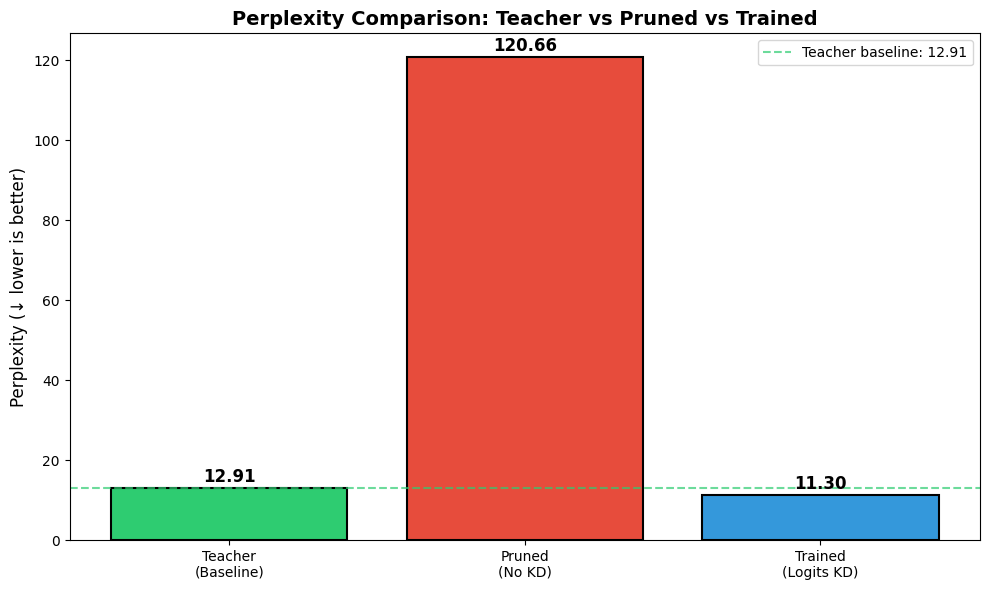


✓ Recovery: 101.5% of degradation recovered


In [17]:
# Perplexity Bar Chart
models = ['Teacher\n(Baseline)', 'Pruned\n(No KD)', 'Trained\n(Logits KD)']
ppls = [teacher_ppl, student_ppl, trained_ppl]
colors = ['#2ecc71', '#e74c3c', '#3498db']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(models, ppls, color=colors, edgecolor='black', linewidth=1.5)
ax.set_ylabel('Perplexity (↓ lower is better)', fontsize=12)
ax.set_title('Perplexity Comparison: Teacher vs Pruned vs Trained', fontsize=14, fontweight='bold')
for bar, ppl in zip(bars, ppls):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{ppl:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
ax.axhline(y=teacher_ppl, color='#2ecc71', linestyle='--', alpha=0.7, label=f'Teacher baseline: {teacher_ppl:.2f}')
ax.legend()
plt.tight_layout()
plt.savefig('ppl_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Recovery: {recovery_pct:.1f}% of degradation recovered")

In [18]:
# Inspeccionar estructura de benchmark_results
print("Keys en benchmark_results:", benchmark_results.keys())
print("\nEstructura de 'teacher':")
print(type(benchmark_results['teacher']))
if isinstance(benchmark_results['teacher'], dict):
    print("Keys:", benchmark_results['teacher'].keys())
    # Ver un ejemplo de tarea
    for key in list(benchmark_results['teacher'].keys())[:2]:
        print(f"\n{key}: {benchmark_results['teacher'][key]}")

Keys en benchmark_results: dict_keys(['teacher', 'student_pruned', 'logits_only_trained'])

Estructura de 'teacher':
<class 'dict'>
Keys: dict_keys(['arc_easy', 'hellaswag', 'lambada_openai', 'piqa', 'winogrande'])

arc_easy: {'accuracy': '0.5880', 'acc_norm': '0.5694'}

hellaswag: {'accuracy': '0.3424', 'acc_norm': '0.4143'}


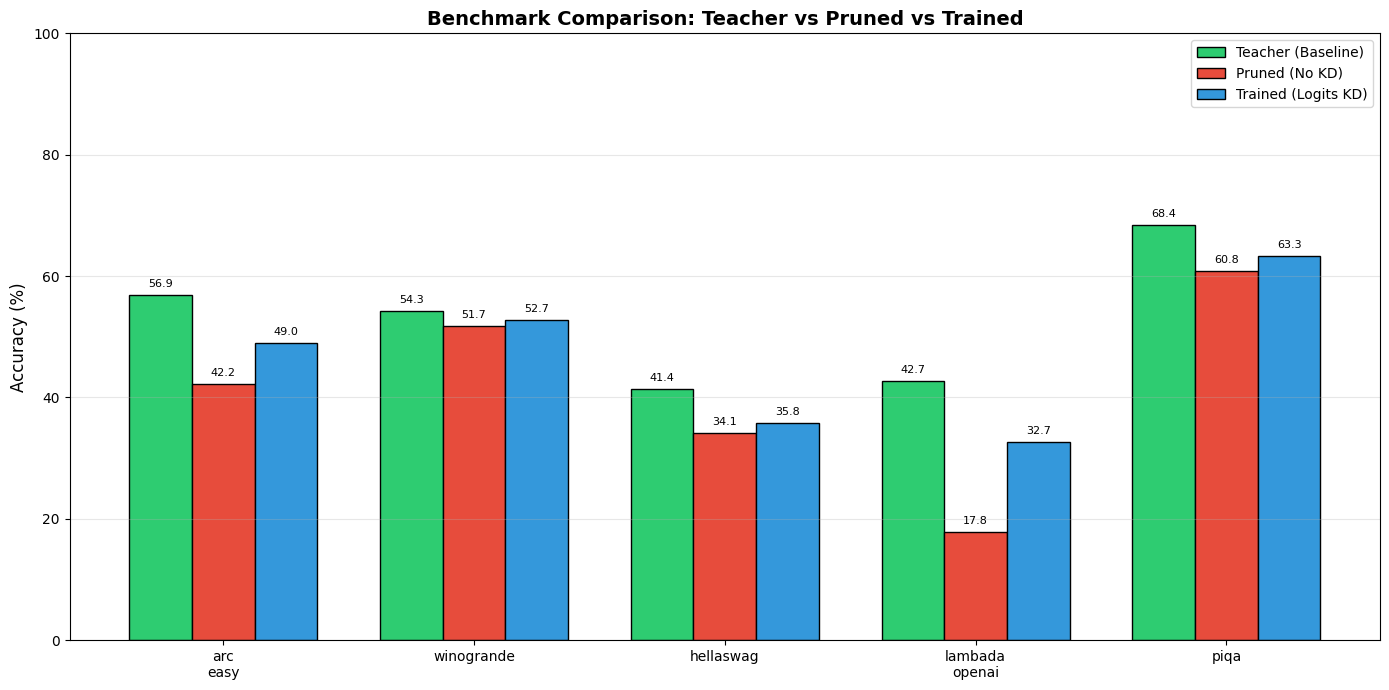


Benchmark Average: Teacher=52.8%, Pruned=41.3%, Trained=46.7%
Benchmark Recovery: 47.2%

Detalle por tarea:
  arc_easy            : Teacher=56.9%  Pruned=42.2%  Trained=49.0%
  winogrande          : Teacher=54.3%  Pruned=51.7%  Trained=52.7%
  hellaswag           : Teacher=41.4%  Pruned=34.1%  Trained=35.8%
  lambada_openai      : Teacher=42.7%  Pruned=17.8%  Trained=32.7%
  piqa                : Teacher=68.4%  Pruned=60.8%  Trained=63.3%


In [19]:
# Benchmark Bar Chart
if RUN_FULL_BENCHMARKS and benchmark_results:
    tasks = BENCHMARK_TASKS
    x = np.arange(len(tasks))
    width = 0.25

    # Función helper para extraer scores con fallback
    def get_score(model_results, task):
        task_data = model_results.get(task, {})
        # Prioridad: acc_norm, luego accuracy
        score_str = task_data.get('acc_norm', task_data.get('accuracy', '0'))
        return float(score_str) * 100

    teacher_scores = [get_score(benchmark_results['teacher'], t) for t in tasks]
    pruned_scores = [get_score(benchmark_results['student_pruned'], t) for t in tasks]
    trained_scores = [get_score(benchmark_results['logits_only_trained'], t) for t in tasks]

    fig, ax = plt.subplots(figsize=(14, 7))
    bars1 = ax.bar(x - width, teacher_scores, width, label='Teacher (Baseline)', color='#2ecc71', edgecolor='black')
    bars2 = ax.bar(x, pruned_scores, width, label='Pruned (No KD)', color='#e74c3c', edgecolor='black')
    bars3 = ax.bar(x + width, trained_scores, width, label='Trained (Logits KD)', color='#3498db', edgecolor='black')

    ax.set_ylabel('Accuracy (%)', fontsize=12)
    ax.set_title('Benchmark Comparison: Teacher vs Pruned vs Trained', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([t.replace('_', '\n') for t in tasks], fontsize=10)
    ax.legend(loc='upper right')
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)

    def add_labels(bars):
        for bar in bars:
            h = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, h + 1, f'{h:.1f}', ha='center', va='bottom', fontsize=8)

    add_labels(bars1)
    add_labels(bars2)
    add_labels(bars3)

    plt.tight_layout()
    plt.savefig('benchmark_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print average recovery
    avg_teacher = np.mean(teacher_scores)
    avg_pruned = np.mean(pruned_scores)
    avg_trained = np.mean(trained_scores)
    bench_degradation = avg_teacher - avg_pruned
    bench_recovered = avg_trained - avg_pruned
    bench_recovery_pct = (bench_recovered / bench_degradation) * 100 if bench_degradation > 0 else 0

    print(f"\nBenchmark Average: Teacher={avg_teacher:.1f}%, Pruned={avg_pruned:.1f}%, Trained={avg_trained:.1f}%")
    print(f"Benchmark Recovery: {bench_recovery_pct:.1f}%")

    # Detalle por tarea
    print("\nDetalle por tarea:")
    for i, task in enumerate(tasks):
        print(f"  {task:20s}: Teacher={teacher_scores[i]:.1f}%  Pruned={pruned_scores[i]:.1f}%  Trained={trained_scores[i]:.1f}%")

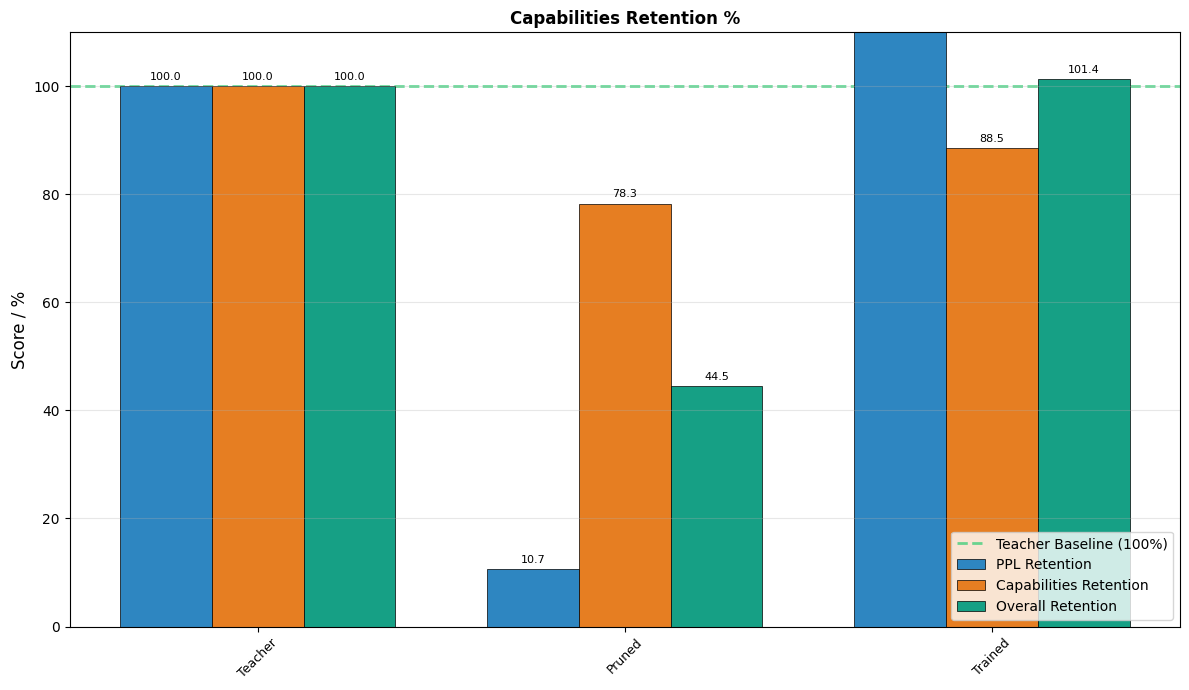


RETENTION SUMMARY (vs Teacher Baseline)
Model                 PPL Ret %       Cap Ret %       Overall %
----------------------------------------------------------------------
Teacher                  100.0%          100.0%          100.0%
Pruned                    10.7%           78.3%           44.5%
Trained                  114.2%           88.5%          101.4%

KEY INSIGHTS:
  • PPL Retention: 114.2% (Teacher PPL / Student PPL)
  • Capabilities Retention: 88.5% (Avg benchmark score / Teacher score)
  • Overall Retention: 101.4% (Average of both metrics)

  • KD Training recovered 56.9 percentage points


In [20]:
# Capabilities Retention
if RUN_FULL_BENCHMARKS and benchmark_results:


    # A. Capabilities Retention (
    teacher_avg_acc = np.mean(teacher_scores)
    pruned_avg_acc = np.mean(pruned_scores)
    trained_avg_acc = np.mean(trained_scores)

    cap_retention = {
        'teacher': 100.0,
        'pruned': (pruned_avg_acc / teacher_avg_acc * 100) if teacher_avg_acc > 0 else 0,
        'trained': (trained_avg_acc / teacher_avg_acc * 100) if teacher_avg_acc > 0 else 0
    }

    # B. PPL Retention
    # Fórmula: (Teacher PPL / Student PPL) * 100
    ppl_retention = {
        'teacher': 100.0,
        'pruned': (teacher_ppl / student_ppl * 100) if student_ppl > 0 else 0,
        'trained': (teacher_ppl / trained_ppl * 100) if trained_ppl > 0 else 0
    }

    # C. Overall Retention Score
    overall_retention = {
        'teacher': 100.0,
        'pruned': (ppl_retention['pruned'] + cap_retention['pruned']) / 2,
        'trained': (ppl_retention['trained'] + cap_retention['trained']) / 2
    }


    model_names = ['Teacher', 'Pruned', 'Trained']
    model_keys = ['teacher', 'pruned', 'trained']

    colors_models = ['#2ecc71', '#e74c3c', '#5dade2']  # Green, Red, Blue

    retention_metrics = {
        'PPL Retention %': [ppl_retention[k] for k in model_keys],
        'Capabilities Retention %': [cap_retention[k] for k in model_keys],
        'Overall Retention Score %': [overall_retention[k] for k in model_keys]
    }


    fig, ax = plt.subplots(figsize=(12, 7))

    x = np.arange(len(model_names))
    width = 0.25

    bars1 = ax.bar(x - width, retention_metrics['PPL Retention %'], width,
                   label='PPL Retention', color='#2e86c1', edgecolor='black', linewidth=0.5)
    bars2 = ax.bar(x, retention_metrics['Capabilities Retention %'], width,
                   label='Capabilities Retention', color='#e67e22', edgecolor='black', linewidth=0.5)
    bars3 = ax.bar(x + width, retention_metrics['Overall Retention Score %'], width,
                   label='Overall Retention', color='#16a085', edgecolor='black', linewidth=0.5)

    ax.axhline(y=100, color='#2ecc71', linestyle='--', linewidth=2, alpha=0.7,
               label='Teacher Baseline (100%)', zorder=0)

    ax.set_ylabel('Score / %', fontsize=12)
    ax.set_title('Capabilities Retention %', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.tick_params(axis='x', rotation=45, labelsize=9)
    ax.legend(loc='lower right', fontsize=10)
    ax.set_ylim(0, 110)
    ax.grid(True, alpha=0.3, axis='y')

    def add_bar_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.1f}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)

    add_bar_labels(bars1)
    add_bar_labels(bars2)
    add_bar_labels(bars3)

    plt.tight_layout()
    plt.savefig('capabilities_retention_summary.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\n{'='*70}")
    print(f"RETENTION SUMMARY (vs Teacher Baseline)")
    print(f"{'='*70}")
    print(f"{'Model':<15} {'PPL Ret %':>15} {'Cap Ret %':>15} {'Overall %':>15}")
    print(f"{'-'*70}")
    for i, key in enumerate(model_keys):
        print(f"{model_names[i]:<15} {ppl_retention[key]:>14.1f}% {cap_retention[key]:>14.1f}% {overall_retention[key]:>14.1f}%")
    print(f"{'='*70}")

    print(f"\nKEY INSIGHTS:")
    print(f"  • PPL Retention: {ppl_retention['trained']:.1f}% (Teacher PPL / Student PPL)")
    print(f"  • Capabilities Retention: {cap_retention['trained']:.1f}% (Avg benchmark score / Teacher score)")
    print(f"  • Overall Retention: {overall_retention['trained']:.1f}% (Average of both metrics)")
    print(f"\n  • KD Training recovered {overall_retention['trained'] - overall_retention['pruned']:.1f} percentage points")

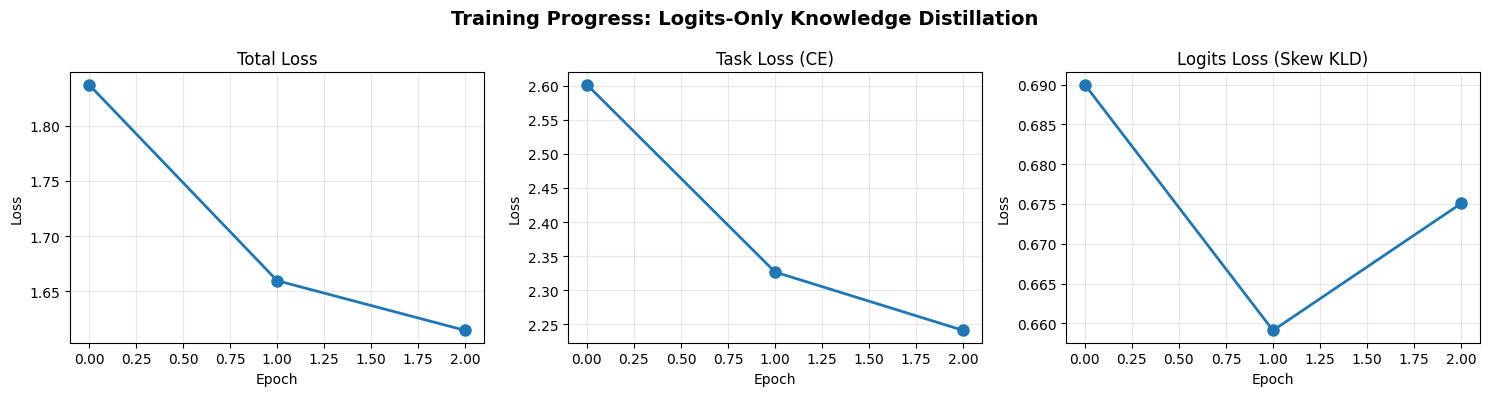

In [21]:
# Training Loss Curves - Extract only relevant losses (trajectory & derivative are 0)
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
loss_keys = [
    ('total', 'Total Loss'),
    ('task', 'Task Loss (CE)'),
    ('logits', 'Logits Loss (Skew KLD)')
]
for idx, (key, title) in enumerate(loss_keys):
    axes[idx].plot(history[key], marker='o', linewidth=2, markersize=8)
    axes[idx].set_title(title, fontsize=12)
    axes[idx].set_xlabel('Epoch')
    axes[idx].set_ylabel('Loss')
    axes[idx].grid(True, alpha=0.3)
plt.suptitle('Training Progress: Logits-Only Knowledge Distillation', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

## Section 6.5: Save Experiment Results

In [22]:
# Section 6.5: Save Experiment Results
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer): return int(obj)
        if isinstance(obj, np.floating): return float(obj)
        if isinstance(obj, np.ndarray): return obj.tolist()
        return super().default(obj)

def calculate_retention_metrics(model_ppl, model_bench_scores, teacher_ppl, teacher_bench_scores):
    """
    Calcula las métricas de retención vs teacher
    """
    # A. PPL Retention
    ppl_retention = (teacher_ppl / model_ppl * 100) if model_ppl > 0 else 0

    # B. Capabilities Retention
    teacher_avg = np.mean(teacher_bench_scores)
    model_avg = np.mean(model_bench_scores)
    cap_retention = (model_avg / teacher_avg * 100) if teacher_avg > 0 else 0

    # C. Overall Retention
    individual_retentions = []
    for i in range(len(teacher_bench_scores)):
        if teacher_bench_scores[i] > 0:
            ret = (model_bench_scores[i] / teacher_bench_scores[i] * 100)
            individual_retentions.append(ret)

    individual_retentions.append(ppl_retention)

    overall_retention = np.mean(individual_retentions)

    return {
        "retention_%": round(ppl_retention, 2),
        "cap_retention_%": round(cap_retention, 2),
        "overall_retention_%": round(overall_retention, 2)
    }

teacher_retention = calculate_retention_metrics(
    teacher_ppl, teacher_scores, teacher_ppl, teacher_scores
)

pruned_retention = calculate_retention_metrics(
    student_ppl, pruned_scores, teacher_ppl, teacher_scores
)

trained_retention = calculate_retention_metrics(
    trained_ppl, trained_scores, teacher_ppl, teacher_scores
)

results_data = {
    "metadata": {
        "experiment_name": "Logits-Only KD with Skew KLD",
        "timestamp": datetime.now().isoformat(),
        "dataset": "Cosmopedia (40k samples)",
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE
    },
    "models": {
        "teacher": MODEL_NAME,
        "student": f"Gemma-270m-Pruned ({n_student_layers} layers)"
    },
    "training_config": {
        "alpha": 0.5,
        "beta": 0.5,
        "gamma": 0.0,
        "delta": 0.0,
        "skew_alpha": 0.0,
        "temperature": 2.0,
        "learning_rate": LEARNING_RATE,
        "accumulation_steps": 4
    },
    "results": {
        "teacher": {
            "perplexity": round(teacher_ppl, 2),
            "loss": round(teacher_loss, 4),
            "retention_%": teacher_retention["retention_%"],
            "cap_retention_%": teacher_retention["cap_retention_%"],
            "overall_retention_%": teacher_retention["overall_retention_%"]
        },
        "student_pruned": {
            "perplexity": round(student_ppl, 2),
            "loss": round(student_loss, 4),
            "retention_%": pruned_retention["retention_%"],
            "cap_retention_%": pruned_retention["cap_retention_%"],
            "overall_retention_%": pruned_retention["overall_retention_%"]
        },
        "logits_only_trained": {
            "perplexity": round(trained_ppl, 2),
            "loss": round(trained_loss, 4),
            "recovery_pct": round(recovery_pct, 1),
            "retention_%": trained_retention["retention_%"],
            "cap_retention_%": trained_retention["cap_retention_%"],
            "overall_retention_%": trained_retention["overall_retention_%"]
        }
    }
}

if RUN_FULL_BENCHMARKS and benchmark_results:
    for model_key in ['teacher', 'student_pruned', 'logits_only_trained']:
        if model_key in benchmark_results:
            results_data['results'][model_key]['benchmarks'] = benchmark_results[model_key]

json_path = "/content/drive/MyDrive/ch06nb01/CH06_NB02_Logits_KLD_results.json"
os.makedirs(os.path.dirname(json_path), exist_ok=True)
with open(json_path, 'w') as f:
    json.dump(results_data, f, indent=2, cls=NumpyEncoder)
print(f"✓ Results saved to: {json_path}")

with open("CH06_NB02_Logits_KLD_results.json", 'w') as f:
    json.dump(results_data, f, indent=2, cls=NumpyEncoder)
print("✓ Local backup saved")

# Mostrar resumen de retención
print(f"\n{'='*70}")
print(f"RETENTION METRICS SAVED TO JSON")
print(f"{'='*70}")
print(f"{'Model':<20} {'PPL Ret':>12} {'Cap Ret':>12} {'Overall':>12}")
print(f"{'-'*70}")
print(f"{'Teacher':<20} {teacher_retention['retention_%']:>11.2f}% {teacher_retention['cap_retention_%']:>11.2f}% {teacher_retention['overall_retention_%']:>11.2f}%")
print(f"{'Pruned':<20} {pruned_retention['retention_%']:>11.2f}% {pruned_retention['cap_retention_%']:>11.2f}% {pruned_retention['overall_retention_%']:>11.2f}%")
print(f"{'Trained':<20} {trained_retention['retention_%']:>11.2f}% {trained_retention['cap_retention_%']:>11.2f}% {trained_retention['overall_retention_%']:>11.2f}%")
print(f"{'='*70}")

✓ Results saved to: /content/drive/MyDrive/ch06nb01/CH06_NB02_Logits_KLD_results.json
✓ Local backup saved

RETENTION METRICS SAVED TO JSON
Model                     PPL Ret      Cap Ret      Overall
----------------------------------------------------------------------
Teacher                   100.00%      100.00%      100.00%
Pruned                     10.70%       78.30%       65.46%
Trained                   114.20%       88.55%       92.16%


## Section 7: Save Model to Hugging Face

In [ ]:
print(f"Saving model to HuggingFace as '{HF_MODEL_NAME}'...")
student_trained.push_to_hub(HF_MODEL_NAME, commit_message="Depth-pruned Gemma-3-270m with Logits-Only KD")
tokenizer.push_to_hub(HF_MODEL_NAME, commit_message="Tokenizer for gem-3-small")
print(f"✓ Model saved: https://huggingface.co/{HF_MODEL_NAME}")